Simulated Annealing
=======

# Theory

## Definition


## Examples


# Implementation


## Imports

In [6]:
import matplotlib
import numpy as np
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [7]:
# cost function
cost_func = lambda x : - 30*np.sin(x) - x**2          # function to optimize
neighborhood_range = [-5,5]                         # search neighborhood limits
x_0 = 2.5                                           # starting value search

# cooling schedule
cooling_func = lambda t : 1000*np.exp(-0.7*t)       # temperature decay function
cooling_window = [0,20]                             # cooling function domain

## Algorithm


In [8]:
def SA(cost_func: Callable, x_0: float, cooling_schedule: tuple[Callable, list], neighborhood_range: list = [-1,1], maxiter: int = int(5e2), task: str = "maximization") -> tuple[float, list, int]:
    '''
    Simulated annealing algorithm to approximated the global optimum of a given cost function

    Args:
        cost_func: _description_
        x_0: _description_
        cooling_schedule: _description_
        maxiter: _description_. Defaults to int(1e3).
        task: _description_. Defaults to "minimization".

    Returns:
        _description_
    '''
    
    factor = 1 if task == "minimization" else -1
    cooling_func, cooling_window = cooling_schedule

    # algorithm data
    T = cooling_func( np.linspace(*cooling_window, num=maxiter) )
    cost = [cost_func(x_0)]
    x = [x_0]
    accepted_samples=0

    for i in range(maxiter-1):
        
        x_neighbor = x[-1] + np.random.uniform(*neighborhood_range)
        delta_cost = ( cost_func(x_neighbor) - cost_func(x[-1]) )*factor

        # accept if neighbor is better, or accept with energy-driven probability if worse
        if delta_cost <= 0 or np.exp(-delta_cost/T[i]) > np.random.uniform(0,1):
            x.append(x_neighbor)
            cost.append(cost_func(x_neighbor))
            accepted_samples+=1

        # reject bad neighbor "stay where you are"
        else:
            x.append(x[-1])
            cost.append(cost_func(x[-1]))


    x_optimal, history = x[-1], pd.DataFrame({"cost": cost, "x": x, "temperature": T})

    return x_optimal, accepted_samples, history

## Results Visualization & Basic Convergence Analysis


In [9]:
x_optimal, accepted_samples, history = SA(cost_func=cost_func, 
                                          x_0=x_0, 
                                          cooling_schedule=(cooling_func, cooling_window), 
                                          neighborhood_range=neighborhood_range
                                          )

In [11]:
%%capture
fig, ax = plt.subplots(figsize=(6,6))

# fine domain and range limits
xx = np.linspace(history["x"].min()-4, history["x"].max()+4, num=100)
y_lim = [np.min(cost_func(xx))-0.2*np.ptp(cost_func(xx)), np.max(cost_func(xx))+0.2*np.ptp(cost_func(xx))]

# simulated annealing sampling animation 
## statics components
main_function,      = ax.plot(xx, cost_func(xx), "k")
sample_x_ticks,     = ax.plot([history["x"][0]], [y_lim[0]], "r|", clip_on=False, zorder=100)
sample_line,        = ax.plot([], [], "r--")
sample_point,       = ax.plot([], [], "ro")
temperature_count,  = ax.plot([], [], "k>", label="Temperature = "+"{:.2f}".format(history["temperature"][0]))

## decorations
ax.set(xlabel="x", ylabel="f(x)", ylim=y_lim, title="Simulated Annealing Sampling")
legend = ax.legend()
ax.grid(True)

def animate(frame: int) -> tuple:

    ## animated components
    sample_line.set_data([history["x"][frame], history["x"][frame]], [y_lim[0], cost_func(history["x"][frame])])
    sample_point.set_data([history["x"][frame]], [cost_func(history["x"][frame])])
    sample_x_ticks.set_data([history["x"][:frame]], [y_lim[0]])
    legend.get_texts()[0].set_text("Temperature = "+"{:.2f}".format(history["temperature"][frame]))

    return sample_line, sample_point, sample_x_ticks

ani = FuncAnimation(fig, animate, frames=len(history["x"]), blit=True, interval=30)

ani.save('./animation.gif', writer=PillowWriter(fps=30))

<div style="text-align:center"><img src="./animation.gif" width="500"/></div>

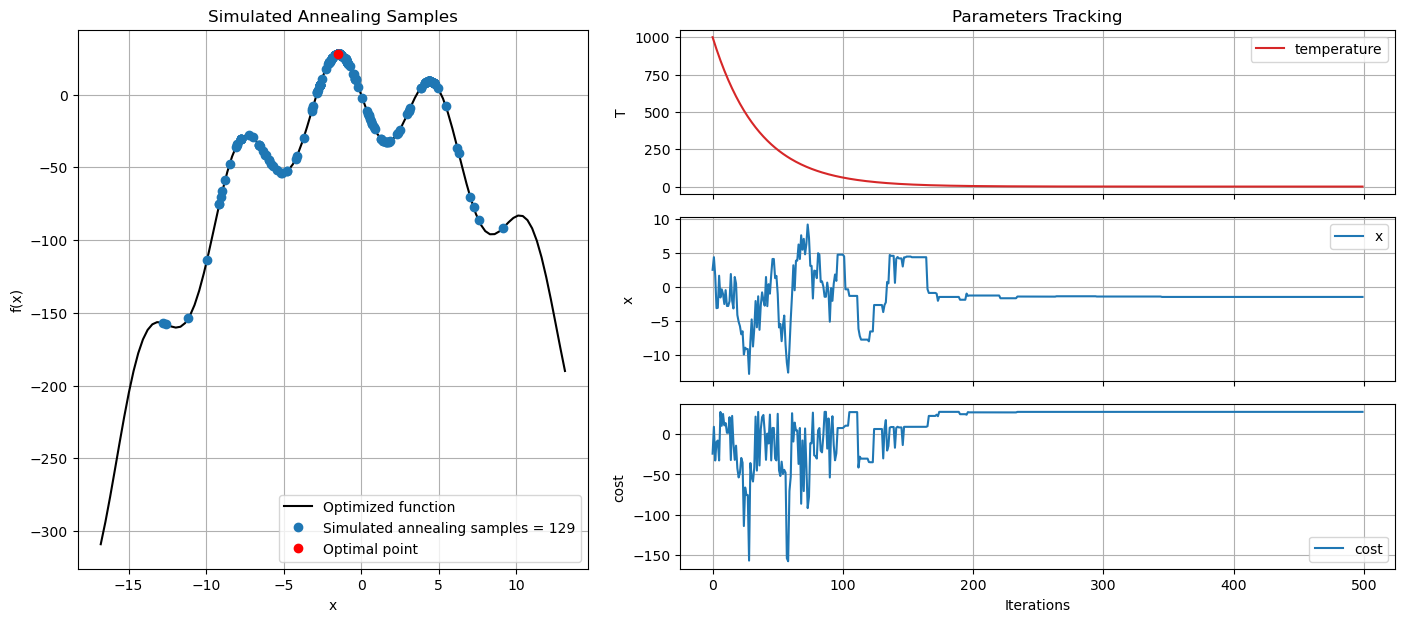

,Property,Value
0,optimal x,-1.48454
1,cost at optimal x,27.684608
2,total search samples,500 samples
3,accepted samples,129 samples
4,rejected samples,371 samples


In [12]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
                              ['upper left',       'right'],
                              ['upper left', 'lower right']],
                             figsize=(17,7), gridspec_kw={'width_ratios': [1, 1.4]})


# simulated annealing sampling plot
ax['upper left'].plot(xx, cost_func(xx), "k", label="Optimized function")
ax['upper left'].plot(history["x"], cost_func(history["x"]), "o", label=f"Simulated annealing samples = {accepted_samples}")
ax['upper left'].plot(x_optimal, cost_func(x_optimal), "ro", label="Optimal point")
ax['upper left'].set(xlabel="x", ylabel="f(x)", title="Simulated Annealing Samples")
ax['upper left'].grid(True)
ax['upper left'].legend()

# temperature value tracking
ax['upper right'].plot(history["temperature"], "tab:red", label="temperature")
ax['upper right'].set(ylabel="T", title="Parameters Tracking")
ax['upper right'].xaxis.set_ticklabels([])
ax['upper right'].grid(True)
ax['upper right'].legend()

# x value tracking
ax['right'].plot(history["x"], label="x")
ax['right'].xaxis.set_ticklabels([])
ax['right'].set(ylabel="x")
ax['right'].grid(True)
ax['right'].legend()

# cost value tracking
ax['lower right'].plot(history["cost"], label="cost")
ax['lower right'].set(xlabel="Iterations", ylabel="cost")
ax['lower right'].grid(True)
ax['lower right'].legend()

# summary
summary = [
    ("optimal x", x_optimal),
    ("cost at optimal x", cost_func(x_optimal)),
    ("total search samples", f'{len(history["x"])} samples'),
    ("accepted samples", f'{accepted_samples} samples'),
    ("rejected samples", f'{len(history["x"]) - accepted_samples} samples')
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Value"])

plt.subplots_adjust(wspace=0.15, hspace=0.14)
plt.show()
df